<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/Object_Detection_CNN(Conv2D%2C%20MaxPooling%2C%20Dropout%2C%20Regulatization%2C%20Keras_Tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages needed

In [1]:
pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE



import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

##Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.2


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Loading cifar10 Dataset**

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [8]:
print("The shape of x train and x test dataset :" , x_train.shape ,x_test.shape)
print("The shape of y train and y test dataset :" , y_train.shape ,y_test.shape)

The shape of x train and x test dataset : (50000, 32, 32, 3) (10000, 32, 32, 3)
The shape of y train and y test dataset : (50000, 1) (10000, 1)


#Review labels for training dataset

In [9]:
#Printing few of the observations for review
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]




# Reviewing the labels

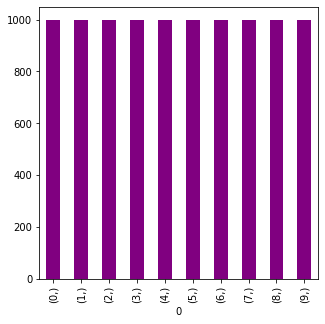

In [10]:
 #Understanding the frequency of labels for test y 
pd.DataFrame(y_test).value_counts()
pd.DataFrame(y_test).value_counts().plot(kind='bar',color='purple', figsize=(5, 5) )

# Visualizing the data 

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

<Figure size 1080x648 with 0 Axes>

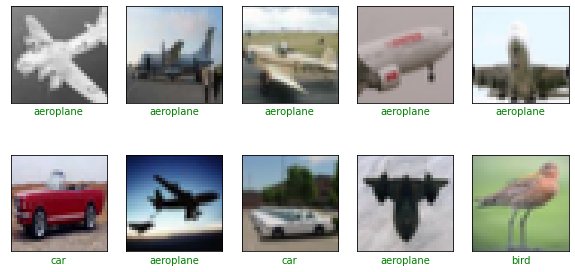

In [13]:
fig = plt.figure(figsize = (15, 9))

class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

## Classes

Preprocess Data For Model Development
The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label	Class_
 - 0	airplane
 - 1	automobile
 - 2	bird
 - 3	cat
 - 4	deer
 - 5	dog
 - 6	frog
 - 7	horse
 - 8	ship
 - 9	truck

In [14]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

#Rescale Examples {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255

Each element in each example is a pixel value
Pixel values range from 0 to 255
0 = black
255 = white

In [15]:
# Normalize from [0:255] => [0.0:1.0]
x_train_norm = np.multiply(x_train, 1.0 / 255.0) 
x_test_norm = np.multiply(x_test, 1.0 / 255.0) 


In [16]:
x_train_norm.shape

(50000, 32, 32, 3)

# Train -Validation Split

In [17]:
print("Size of Dataset: " , len(x_train_norm))
cross_validation_size = int(len(x_train_norm)*0.2)
print("Size of Cross Validation Set: " , cross_validation_size)

Size of Dataset:  50000
Size of Cross Validation Set:  10000


In [18]:
#Splitting train dataset into train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_norm, y_train, test_size=cross_validation_size, random_state=2)

In [19]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

In [20]:
x_train_norm = X_train/255
x_valid_norm = X_valid/255

x_train_norm.shape, x_valid_norm.shape

((40000, 32, 32, 3), (10000, 32, 32, 3))

# **Experiments**

## Common functions

In [21]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true,y_pred):
    fig = plt.figure(figsize=(5,5))
    #matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix(y_true, y_pred),annot=True,fmt='5.0f',cmap="Blues")
    plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
    ax = fig.add_subplot(111)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

In [23]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [24]:
def plot_history(model):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(17,5))
    ax1.plot(model.history.history['val_accuracy'], 'r', label = 'Validation Accuracy')
    ax1.plot(model.history.history['accuracy'], 'b',label = 'Training Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.grid()
    ax1.legend(loc = "upper left")
    ax2.plot(model.history.history['val_loss'], 'r',label = 'Validation Loss')
    ax2.plot(model.history.history['loss'], 'b',label = 'Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation loss')
    ax2.grid()
    plt.legend(loc = "upper left")

In [25]:
results = {}

In [26]:
X_train.shape

(40000, 32, 32, 3)

In [27]:
x_train_reshaped = np.reshape(X_train, (40000, 3072))
x_valid_reshaped = np.reshape(X_valid, (10000, 3072))

In [28]:
x_train_reshaped.shape
X_valid.shape

(10000, 32, 32, 3)

# Data preparation Checkpoint

## E1:  DNN with 2 layers (no regularization)

In [29]:
%load_ext autotime
time_callback_1 = TimeHistory()

tf.keras.backend.clear_session()  # For easy reset of notebook state.

inputs = keras.Input(shape=(3072)) #H x W x Channels
x = layers.Flatten()(inputs)
x = layers.Dense(512 ,activation = 'relu')(x)
x = layers.Dense(256 ,activation = 'relu')(x)
outputs = layers.Dense(10 ,activation = 'softmax')(x)

model1 = keras.Model(inputs=inputs, outputs=outputs, name='exp_1')

# For use with non-categorical labels
model1.compile(optimizer='adam',           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model1.fit(x_train_reshaped,Y_train, validation_data = (x_valid_reshaped,Y_valid), epochs=20, verbose = 1, callbacks = [time_callback_1])
results['exp1'] = history.history

Epoch 1/20
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8945 - accuracy: 0.3163 - val_loss: 1.7624 - val_accuracy: 0.3631
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7030 - accuracy: 0.3867 - val_loss: 1.7462 - val_accuracy: 0.3833
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6253 - accuracy: 0.4164 - val_loss: 1.6303 - val_accuracy: 0.4146
Epoch 4/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5650 - accuracy: 0.4391 - val_loss: 1.5662 - val_accuracy: 0.4360
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5245 - accuracy: 0.4542 - val_loss: 1.5484 - val_accuracy: 0.4589
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5010 - accuracy: 0.4603 - val_loss: 1.5257 - val_accuracy: 0.4571
Epoch 7/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4733 - accuracy: 0.4712 - val_loss: 1.5090 - val_accuracy:

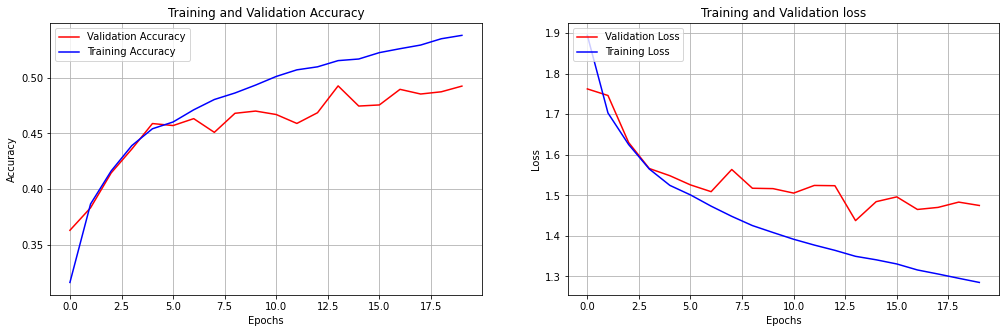

time: 342 ms (started: 2022-07-24 20:00:51 +00:00)


In [30]:
plot_history(model1)

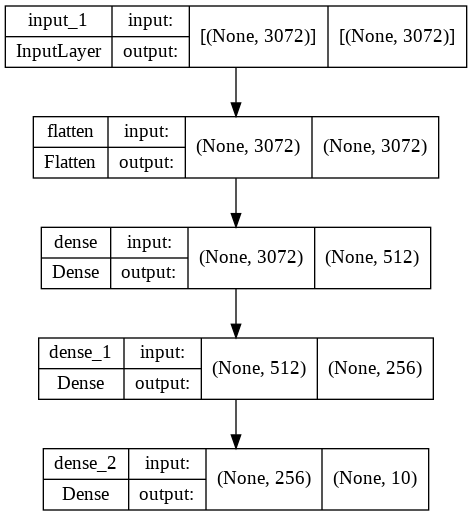

time: 127 ms (started: 2022-07-24 20:00:51 +00:00)


In [31]:
keras.utils.plot_model(model1, "exp1_CIFAR10.png", show_shapes=True)

In [32]:
model1.summary()

Model: "exp_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________
time: 29 ms (started: 2022-07-24 20:00:51 +00:00)


In [33]:
x_test_norm.shape

(10000, 32, 32, 3)

time: 3.46 ms (started: 2022-07-24 20:00:51 +00:00)


In [34]:
x_test_reshaped = np.reshape(x_test_norm, (10000, 3072))
loss, accuracy = model1.evaluate(x_test_reshaped, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.4793 - accuracy: 0.4892
test set accuracy:  48.91999959945679
time: 975 ms (started: 2022-07-24 20:00:51 +00:00)


In [35]:
pred1= model1.predict(x_test_reshaped)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      1000
           1       0.65      0.56      0.60      1000
           2       0.37      0.38      0.37      1000
           3       0.34      0.20      0.25      1000
           4       0.44      0.42      0.43      1000
           5       0.41      0.43      0.42      1000
           6       0.42      0.65      0.51      1000
           7       0.61      0.48      0.54      1000
           8       0.54      0.69      0.60      1000
           9       0.59      0.52      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000

Accuracy Score: 0.4892
Root Mean Square Error: 3.0372355851991464
time: 639 ms (started: 2022-07-24 20:00:52 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


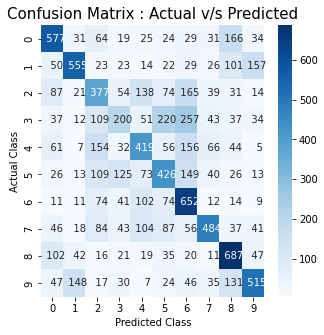

time: 944 ms (started: 2022-07-24 20:00:53 +00:00)


In [36]:
exp0_test_preds = model1.predict(x_test_reshaped)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp0_test_preds.argmax(axis = 1));

In [37]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model1.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_reshaped[:5000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

time: 465 ms (started: 2022-07-24 20:00:54 +00:00)


###sklearn.manifold.TSNE
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [38]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 5000 samples in 0.809s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 6.962911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.910324
[t-SNE] KL divergence after 300 iterations: 2.827725
time: 7.68 s (started: 2022-07-24 20:00:54 +00:00)


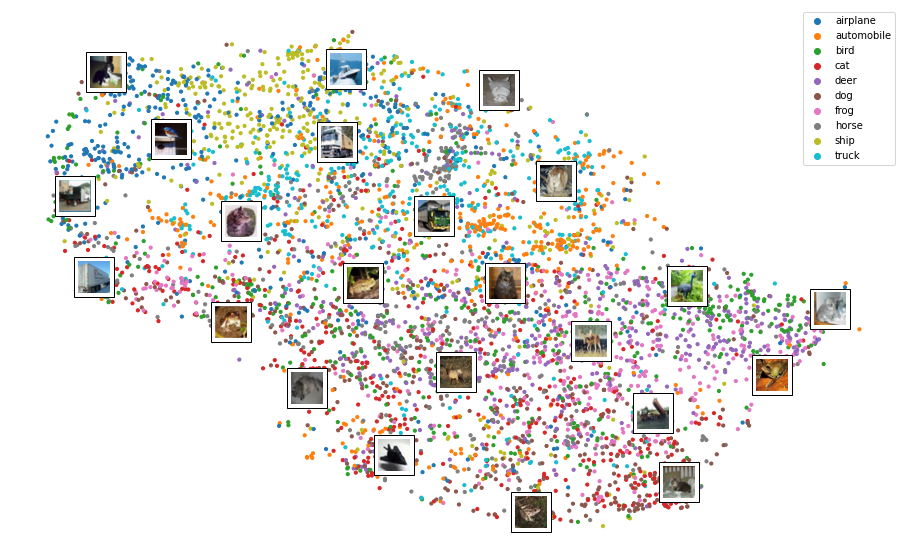

time: 394 ms (started: 2022-07-24 20:01:02 +00:00)


In [39]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## E2:  DNN with 3 layers (no regularization)

In [40]:
%load_ext autotime
time_callback_2 = TimeHistory()

tf.keras.backend.clear_session()  # For easy reset of notebook state.

inputs = keras.Input(shape=(3072)) #H x W x Channels
x = layers.Flatten()(inputs)
x = layers.Dense(512 ,activation = 'relu')(x)
x = layers.Dense(256 ,activation = 'relu')(x)
x = layers.Dense(128 ,activation = 'relu')(x)
outputs = layers.Dense(10 ,activation = 'softmax')(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name='exp_0')

# For use with non-categorical labels
model2.compile(optimizer='adam',           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model2.fit(x_train_reshaped,Y_train, validation_data = (x_valid_reshaped,Y_valid), epochs=20, verbose = 1, callbacks = [time_callback_2])
results['exp2'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8997 - accuracy: 0.3060 - val_loss: 1.7845 - val_accuracy: 0.3570
Epoch 2/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.7076 - accuracy: 0.3837 - val_loss: 1.6838 - val_accuracy: 0.3911
Epoch 3/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.6237 - accuracy: 0.4164 - val_loss: 1.6325 - val_accuracy: 0.4161
Epoch 4/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.5637 - accuracy: 0.4399 - val_loss: 1.5820 - val_accuracy: 0.4388
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5144 - accuracy: 0.4576 - val_loss: 1.5408 - val_accuracy: 0.4502
Epoch 6/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.4838 - accuracy: 0.4661 - val_loss: 1.5420 - val_accuracy: 0.4510
Epoch 7/20
1250/1250 [==============================

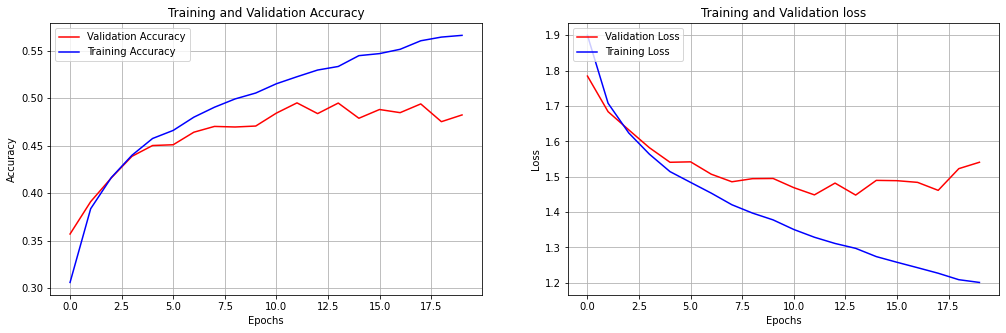

time: 339 ms (started: 2022-07-24 20:02:07 +00:00)


In [41]:
plot_history(model2)

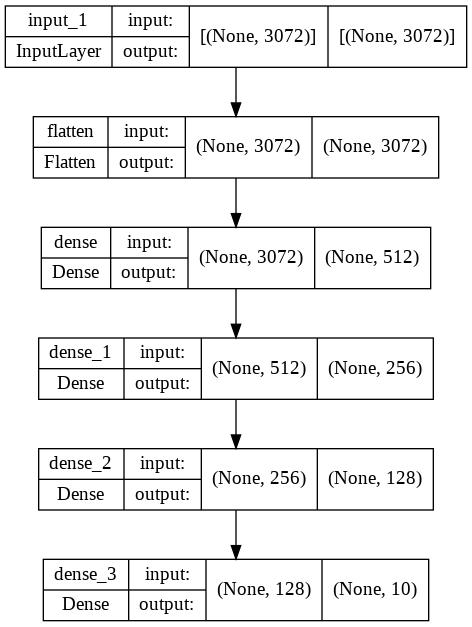

time: 167 ms (started: 2022-07-24 20:02:08 +00:00)


In [42]:
keras.utils.plot_model(model2, "exp2_CIFAR10.png", show_shapes=True)

In [43]:
model2.summary()

Model: "exp_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-train

In [44]:
x_test_reshaped = np.reshape(x_test_norm, (10000, 3072))
loss, accuracy = model2.evaluate(x_test_reshaped, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.5347 - accuracy: 0.4785
test set accuracy:  47.850000858306885
time: 898 ms (started: 2022-07-24 20:02:08 +00:00)


In [45]:
pred1= model2.predict(x_test_reshaped)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.65      0.54      1000
           1       0.57      0.58      0.57      1000
           2       0.40      0.23      0.29      1000
           3       0.34      0.35      0.35      1000
           4       0.43      0.47      0.45      1000
           5       0.51      0.22      0.30      1000
           6       0.46      0.62      0.53      1000
           7       0.60      0.46      0.52      1000
           8       0.54      0.65      0.59      1000
           9       0.49      0.56      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000

Accuracy Score: 0.4785
Root Mean Square Error: 3.2201552757592298
time: 588 ms (started: 2022-07-24 20:02:09 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


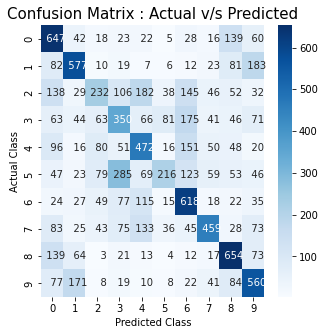

time: 963 ms (started: 2022-07-24 20:02:09 +00:00)


In [46]:
exp01_test_preds = model2.predict(x_test_reshaped)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp01_test_preds.argmax(axis = 1));

In [47]:
x_valid_reshaped.shape

(10000, 3072)

time: 6.25 ms (started: 2022-07-24 20:02:10 +00:00)


In [48]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model2.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_reshaped[:5000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

time: 434 ms (started: 2022-07-24 20:02:10 +00:00)


In [49]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 5000 samples in 0.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 5.143757
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.290604
[t-SNE] KL divergence after 300 iterations: 2.714604
time: 7.67 s (started: 2022-07-24 20:02:11 +00:00)


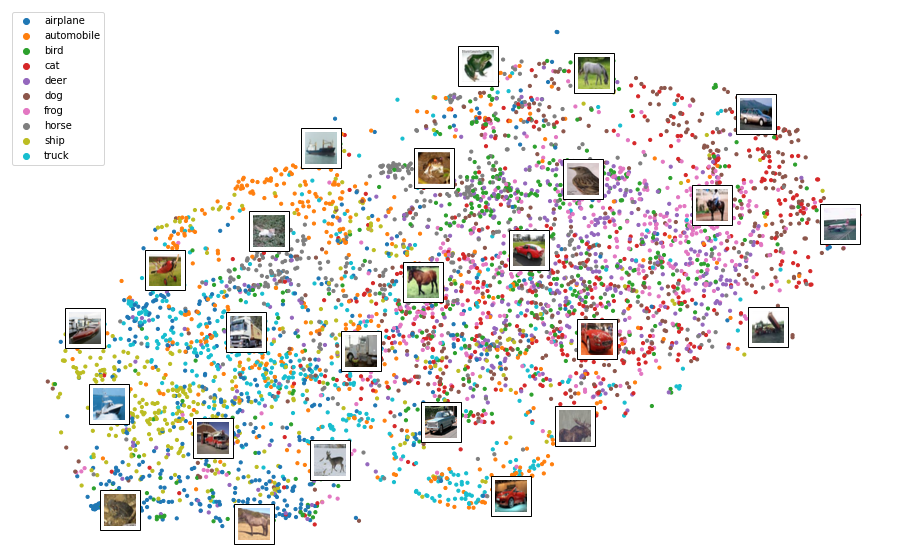

time: 403 ms (started: 2022-07-24 20:02:18 +00:00)


In [50]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:5000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## E3: CNN with 2 convolution/max pooling layers (no regularization)

In [51]:
%load_ext autotime
time_callback_3 = TimeHistory()
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

# For use with non-categorical labels
model.compile(optimizer='adam',           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model.fit(X_train,Y_train, validation_data = (X_valid,Y_valid), epochs=20, verbose = 1, callbacks = [time_callback_3])
results['exp3'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
1250/1250 [==============================] - 11s 8ms/step - loss: 1.5823 - accuracy: 0.4277 - val_loss: 1.3163 - val_accuracy: 0.5380
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2333 - accuracy: 0.5644 - val_loss: 1.2215 - val_accuracy: 0.5708
Epoch 3/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0888 - accuracy: 0.6193 - val_loss: 1.0713 - val_accuracy: 0.6211
Epoch 4/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9929 - accuracy: 0.6527 - val_loss: 1.0237 - val_accuracy: 0.6448
Epoch 5/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9260 - accuracy: 0.6747 - val_loss: 1.0269 - val_accuracy: 0.6452
Epoch 6/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8652 - accuracy: 0.6977 - val_loss: 0.9869 - val_accuracy: 0.6640
Epoch 7/20
1250/1250 [========================

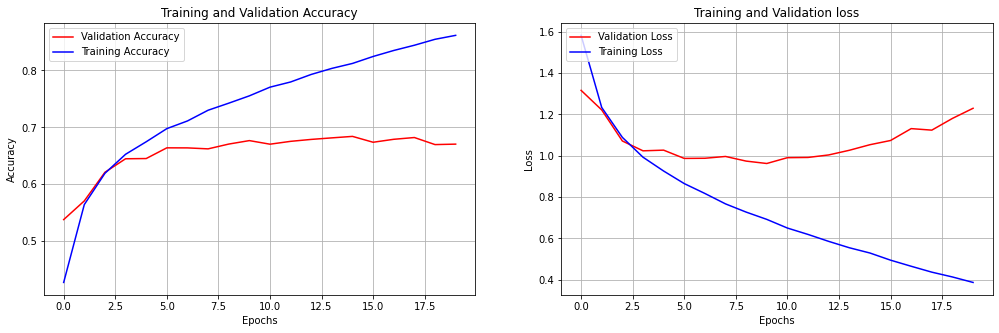

time: 338 ms (started: 2022-07-24 20:05:41 +00:00)


In [52]:
plot_history(model)

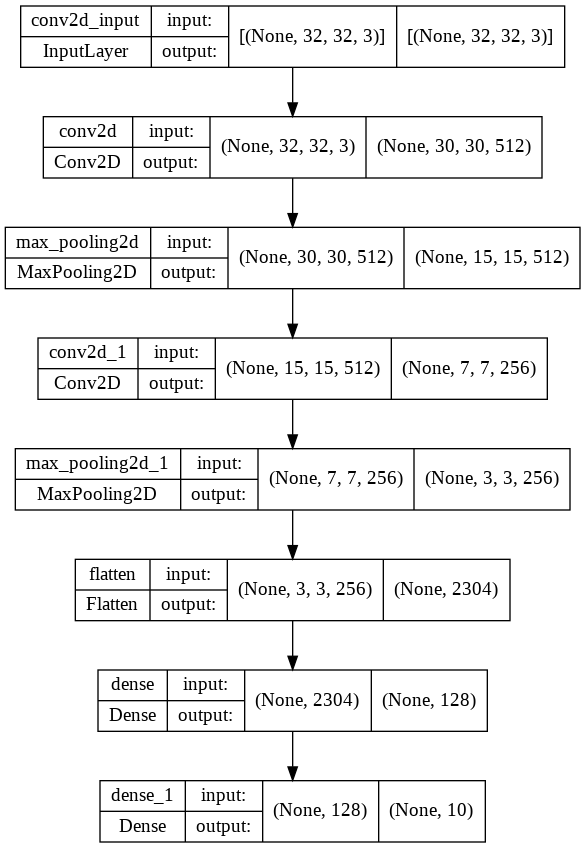

time: 201 ms (started: 2022-07-24 20:05:41 +00:00)


In [53]:
keras.utils.plot_model(model, "Exp3_CIFAR10.png", show_shapes=True)

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [55]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 4ms/step - loss: 1.2347 - accuracy: 0.6692
test set accuracy:  66.92000031471252
time: 1.45 s (started: 2022-07-24 20:05:41 +00:00)


In [56]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1000
           1       0.78      0.81      0.80      1000
           2       0.57      0.55      0.56      1000
           3       0.51      0.45      0.48      1000
           4       0.51      0.72      0.59      1000
           5       0.59      0.56      0.57      1000
           6       0.81      0.70      0.75      1000
           7       0.69      0.69      0.69      1000
           8       0.76      0.81      0.78      1000
           9       0.82      0.72      0.76      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000

Accuracy Score: 0.6692
Root Mean Square Error: 2.327487916187751
time: 1.09 s (started: 2022-07-24 20:05:43 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


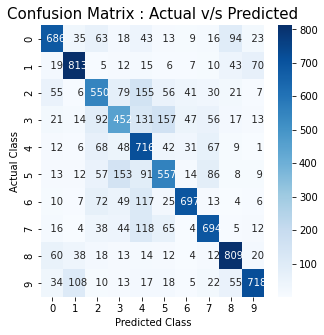

time: 1.72 s (started: 2022-07-24 20:05:44 +00:00)


In [57]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [58]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(X_valid[:2000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

time: 5.93 s (started: 2022-07-24 20:05:46 +00:00)


In [59]:
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(dense_layer_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 2000 samples in 0.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 4.884312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.821350
[t-SNE] KL divergence after 2000 iterations: 2.300027
time: 18.3 s (started: 2022-07-24 20:05:52 +00:00)


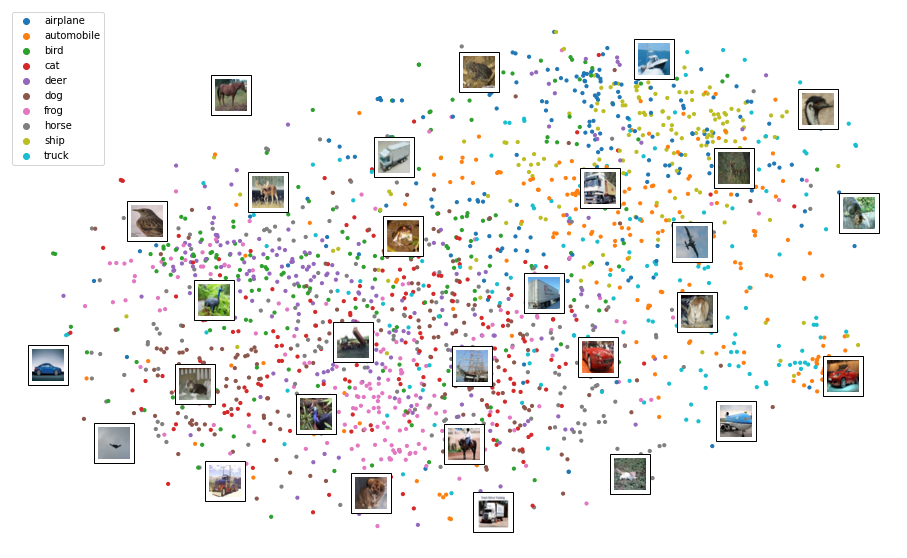

time: 312 ms (started: 2022-07-24 20:06:10 +00:00)


In [60]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

Visualization : Extract the outputs from 2 filters from the 2 max pooling layers and visualize them in a grid as images. See whether the ‘lighted’ up regions correspond to some features in the original images.

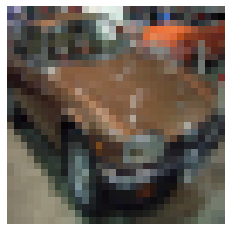

time: 691 ms (started: 2022-07-24 20:06:10 +00:00)


In [61]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2000]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [62]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

time: 6.8 ms (started: 2022-07-24 20:06:11 +00:00)


In [63]:
activations = activation_model.predict(img_tensor)
len(activations)

7

time: 116 ms (started: 2022-07-24 20:06:11 +00:00)


In [64]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

time: 3.83 ms (started: 2022-07-24 20:06:11 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


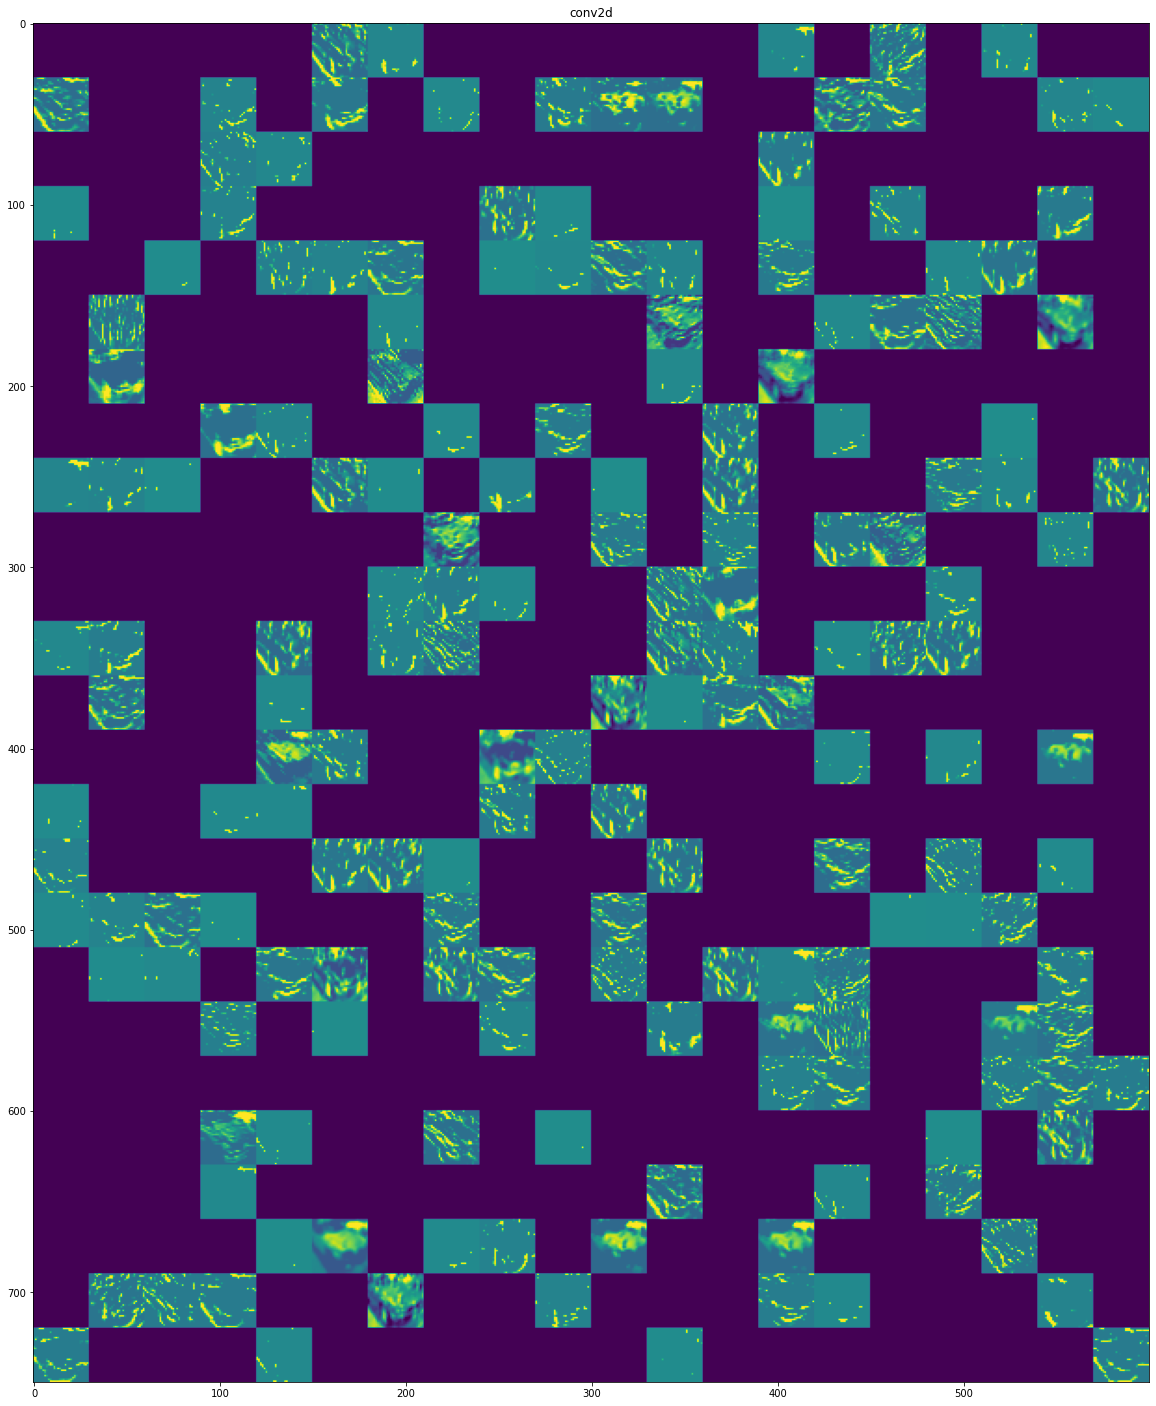

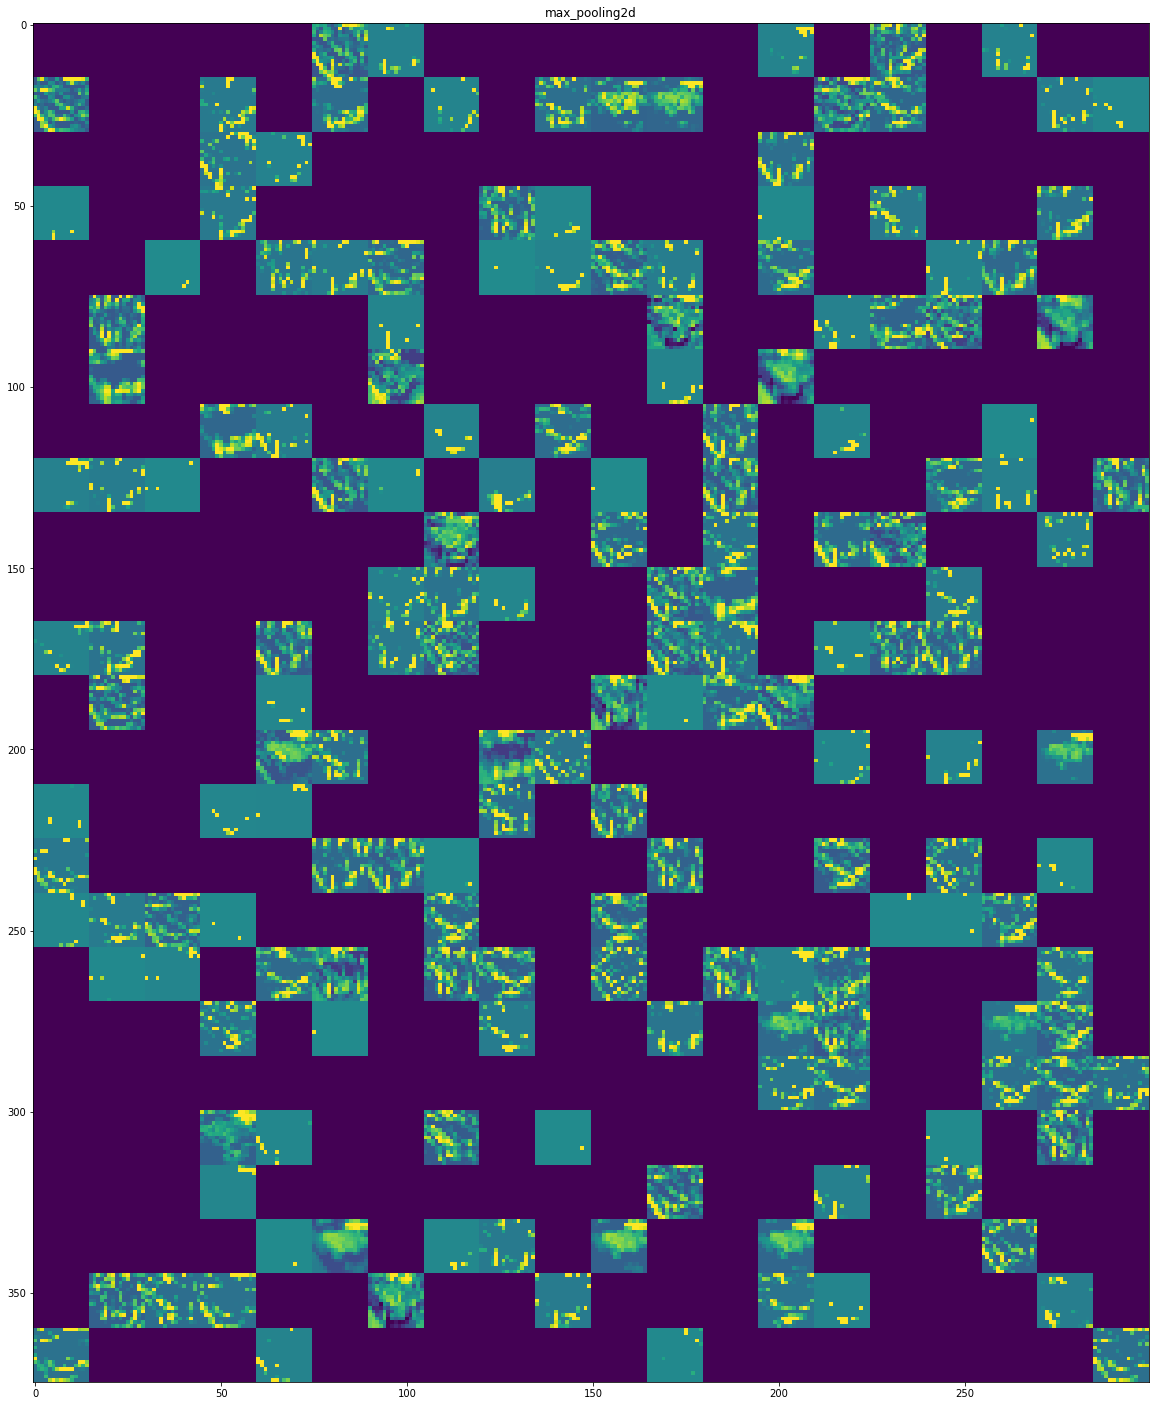

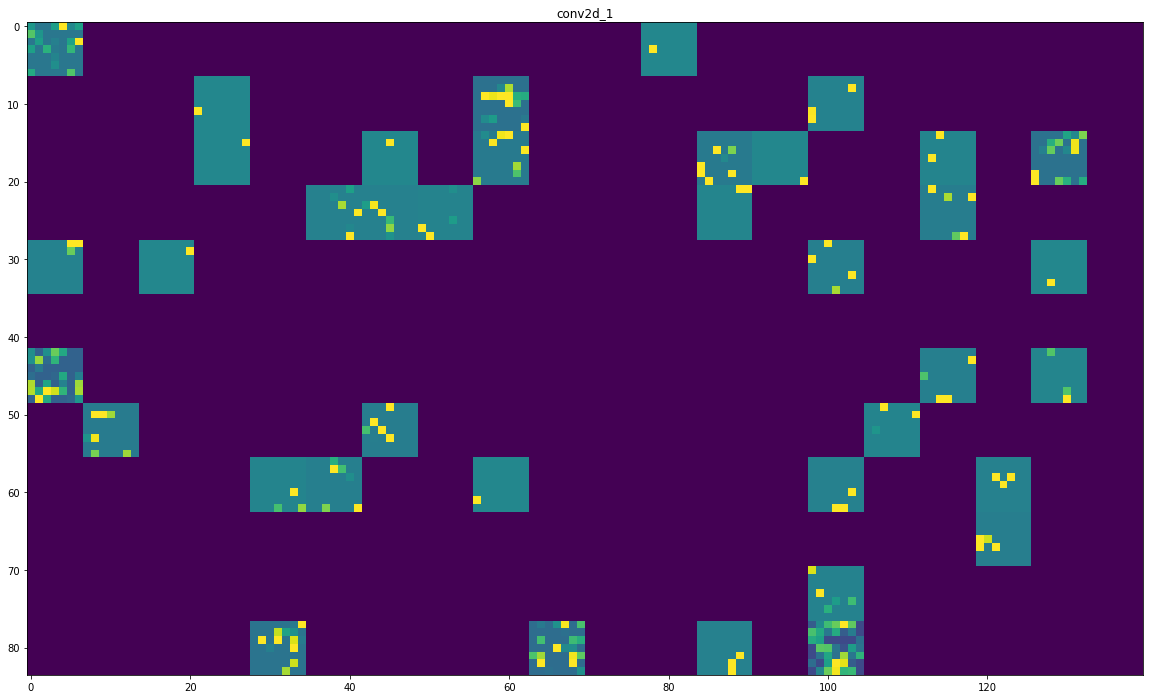

time: 1.56 s (started: 2022-07-24 20:06:11 +00:00)


In [65]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 20

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

plt.show();

In [66]:
# # Extracts the outputs of all layers:
# layer_outputs = [layer.output for layer in model.layers]

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# # Get activation values for the last dense layer
# activations = activation_model.predict(x_valid_reshaped[:5000])
# dense_layer_activations = activations[-3]
# output_layer_activations = activations[-1]

time: 1.5 ms (started: 2022-07-24 20:06:13 +00:00)


In [67]:
# # Reduce the dimension using T-SNE to visualize i n a scatterplot
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(dense_layer_activations)

# # Scaling
# tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

time: 1.26 ms (started: 2022-07-24 20:06:13 +00:00)


In [68]:
# cmap = plt.cm.tab10
# plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:5000], s=10, cmap=cmap)
# plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(tsne_results):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#             position, bboxprops={"lw": 1})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

time: 2.95 ms (started: 2022-07-24 20:06:13 +00:00)


## E4: CNN with 3 convolution/max pooling layers (no regularization)

In [69]:
%load_ext autotime
time_callback_4 = TimeHistory()
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=64, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train,Y_train, validation_data = (X_valid,Y_valid), epochs=20, batch_size=512 , verbose = 1, callbacks = [time_callback_4])
results['exp4'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
79/79 [==============================] - 9s 95ms/step - loss: 1.5414 - accuracy: 0.4470 - val_loss: 2.1152 - val_accuracy: 0.1712
Epoch 2/20
79/79 [==============================] - 7s 89ms/step - loss: 1.1434 - accuracy: 0.5949 - val_loss: 1.8001 - val_accuracy: 0.2932
Epoch 3/20
79/79 [==============================] - 7s 88ms/step - loss: 0.9797 - accuracy: 0.6576 - val_loss: 1.6334 - val_accuracy: 0.3922
Epoch 4/20
79/79 [==============================] - 7s 88ms/step - loss: 0.8618 - accuracy: 0.6982 - val_loss: 1.2515 - val_accuracy: 0.5527
Epoch 5/20
79/79 [==============================] - 7s 88ms/step - loss: 0.7766 - accuracy: 0.7297 - val_loss: 1.1397 - val_accuracy: 0.6078
Epoch 6/20
79/79 [==============================] - 7s 88ms/step - loss: 0.7000 - accuracy: 0.7582 - val_loss: 1.0037 - val_accuracy: 0.6436
Epoch 7/20
79/79 [==============================] - 7s 88ms/step - los

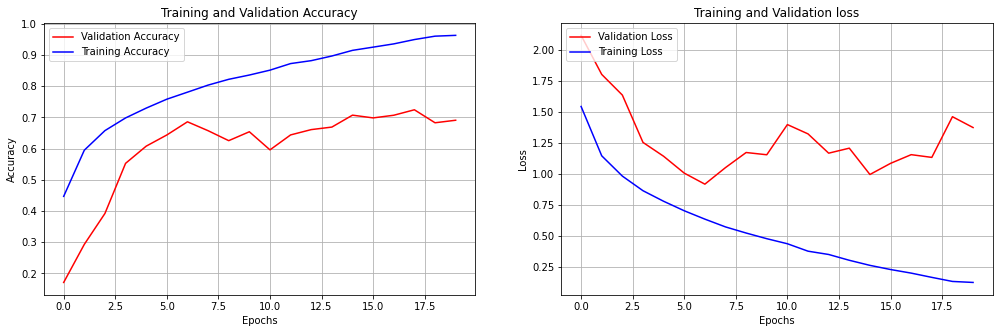

time: 331 ms (started: 2022-07-24 20:08:35 +00:00)


In [70]:
plot_history(model)

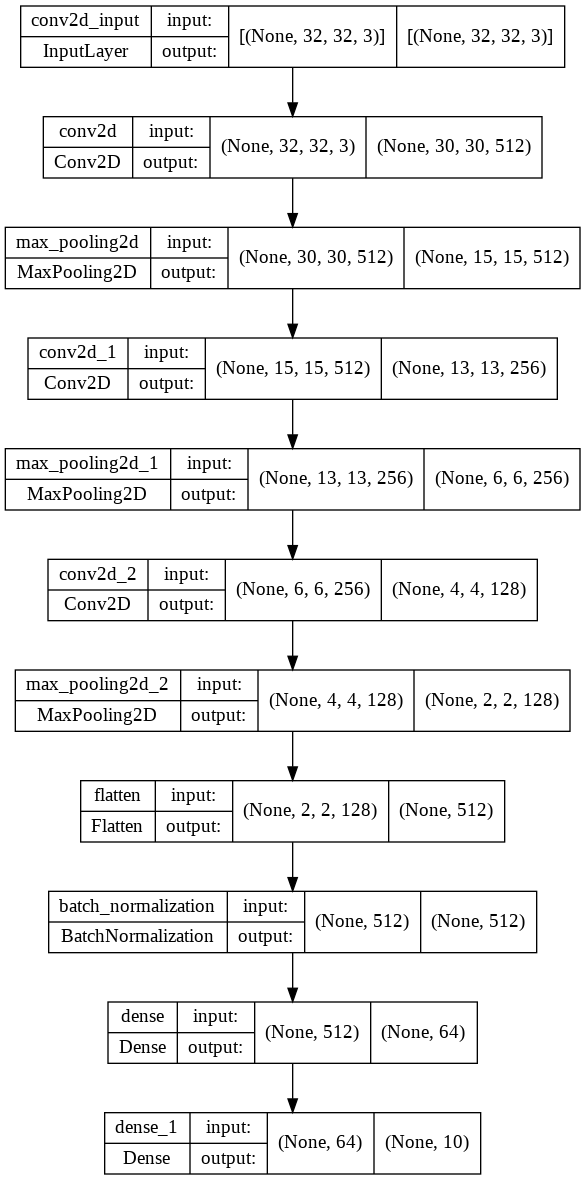

time: 387 ms (started: 2022-07-24 20:08:35 +00:00)


In [71]:
keras.utils.plot_model(model, "Exp4_CIFAR10.png", show_shapes=True)

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [73]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 4ms/step - loss: 1.3546 - accuracy: 0.6950
test set accuracy:  69.49999928474426
time: 1.59 s (started: 2022-07-24 20:08:36 +00:00)


In [74]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1000
           1       0.88      0.80      0.84      1000
           2       0.46      0.76      0.57      1000
           3       0.53      0.57      0.55      1000
           4       0.66      0.58      0.62      1000
           5       0.77      0.54      0.63      1000
           6       0.66      0.87      0.75      1000
           7       0.84      0.64      0.73      1000
           8       0.81      0.82      0.82      1000
           9       0.88      0.69      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.69      0.70     10000

Accuracy Score: 0.695
Root Mean Square Error: 2.2289459392277777
time: 1.22 s (started: 2022-07-24 20:08:37 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


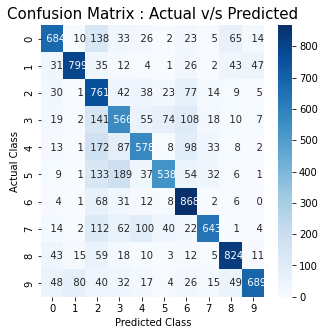

time: 1.58 s (started: 2022-07-24 20:08:38 +00:00)


In [75]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [76]:
# # Extracts the outputs of all layers:
# layer_outputs = [layer.output for layer in model.layers]

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# # Get activation values for the last dense layer
# activations = activation_model.predict(X_valid[:12])
# dense_layer_activations = activations[-3]
# output_layer_activations = activations[-1]

time: 1.07 ms (started: 2022-07-24 20:08:40 +00:00)


In [77]:
# # Reduce the dimension using T-SNE to visualize i n a scatterplot
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(dense_layer_activations)

# # Scaling
# tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

time: 1.27 ms (started: 2022-07-24 20:08:40 +00:00)


In [78]:
# cmap = plt.cm.tab10
# plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:12], s=10, cmap=cmap)
# plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(tsne_results):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#             position, bboxprops={"lw": 1})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

time: 2 ms (started: 2022-07-24 20:08:40 +00:00)


## E5 : DNN with 3 Layer, :2 regularization and dropout layer.

In [79]:
%load_ext autotime
time_callback_5 = TimeHistory()

tf.keras.backend.clear_session()  # For easy reset of notebook state.

image_size = (3072) #H x W x Channels

model = Sequential()
model.add(Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001), input_shape=(image_size,)))
model.add(Dense(units = 256 ,activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(units = 64 ,activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(10 ,activation = 'softmax'))


# For use with non-categorical labels
model.compile(optimizer='adam',           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model.fit(x_train_reshaped,Y_train, validation_data = (x_valid_reshaped,Y_valid), epochs=20, verbose = 1, callbacks = [time_callback_5])
results['exp5'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
1250/1250 [==============================] - 4s 3ms/step - loss: 2.2014 - accuracy: 0.2950 - val_loss: 1.9325 - val_accuracy: 0.3471
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8845 - accuracy: 0.3532 - val_loss: 1.8251 - val_accuracy: 0.3768
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8135 - accuracy: 0.3789 - val_loss: 1.9009 - val_accuracy: 0.3582
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7706 - accuracy: 0.3951 - val_loss: 1.7993 - val_accuracy: 0.4008
Epoch 5/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.7394 - accuracy: 0.4054 - val_loss: 1.7094 - val_accuracy: 0.4242
Epoch 6/20
1250/1250 [==============================] - 3s 3ms/step - loss: 1.7195 - accuracy: 0.4126 - val_loss: 1.7062 - val_accuracy: 0.4244
Epoch 7/20
1250/1250 [==============================

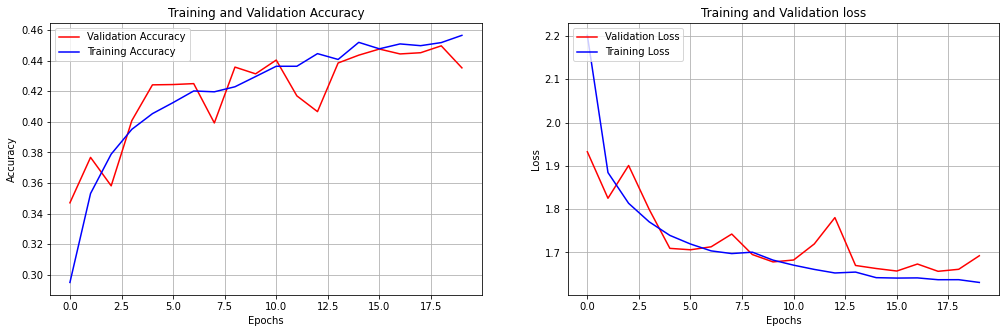

time: 337 ms (started: 2022-07-24 20:09:51 +00:00)


In [80]:
plot_history(model)

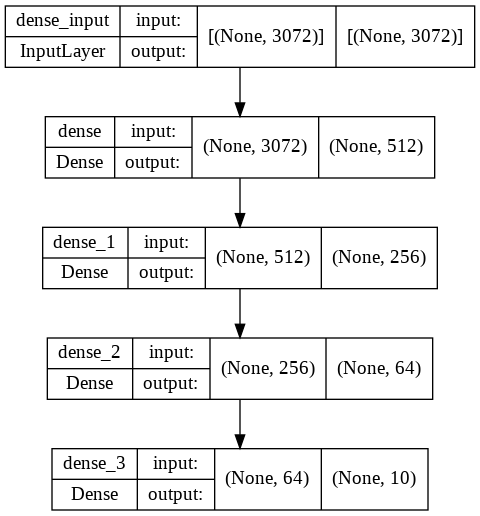

time: 336 ms (started: 2022-07-24 20:09:51 +00:00)


In [81]:
keras.utils.plot_model(model, "Exp5_CIFAR10.png", show_shapes=True)

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,721,802
Trainable params: 1,721,802
Non-trainable params: 0
_________________________________________________________________
time: 27.3 ms (started: 2022-07-24 20:09:52 +00:00)


In [83]:
x_test_reshaped = np.reshape(x_test_norm, (10000, 3072))
loss, accuracy = model.evaluate(x_test_reshaped, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.6867 - accuracy: 0.4434
test set accuracy:  44.33999955654144
time: 1.55 s (started: 2022-07-24 20:09:52 +00:00)


In [84]:
pred1= model.predict(x_test_reshaped)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1000
           1       0.47      0.68      0.56      1000
           2       0.37      0.22      0.28      1000
           3       0.30      0.33      0.31      1000
           4       0.39      0.39      0.39      1000
           5       0.39      0.39      0.39      1000
           6       0.48      0.46      0.47      1000
           7       0.41      0.62      0.49      1000
           8       0.62      0.43      0.51      1000
           9       0.53      0.42      0.47      1000

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.44     10000
weighted avg       0.45      0.44      0.44     10000

Accuracy Score: 0.4434
Root Mean Square Error: 3.235428874198906
time: 590 ms (started: 2022-07-24 20:09:53 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


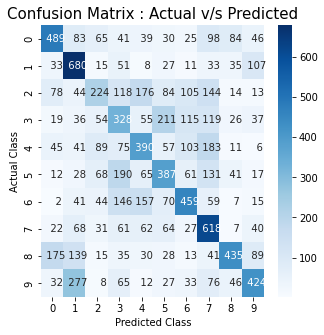

time: 949 ms (started: 2022-07-24 20:09:54 +00:00)


In [85]:
exp_test_preds = model.predict(x_test_reshaped)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

## E6: CNN with 2 convolution/max pooling layers with regularization and  dropout layers

In [86]:
%load_ext autotime
time_callback_6 = TimeHistory()
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2),kernel_regularizer=tf.keras.regularizers.L2(0.001), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(units=64, kernel_regularizer=tf.keras.regularizers.L2(0.001), activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

# For use with non-categorical labels
model.compile(optimizer='adam',           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model.fit(X_train,Y_train, validation_data = 
                    (X_valid,Y_valid), epochs=20, verbose = 1, callbacks = [time_callback_6])
results['exp6'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
1250/1250 [==============================] - 12s 9ms/step - loss: 1.7897 - accuracy: 0.3741 - val_loss: 1.5769 - val_accuracy: 0.4650
Epoch 2/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.5269 - accuracy: 0.4884 - val_loss: 1.4326 - val_accuracy: 0.5283
Epoch 3/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4437 - accuracy: 0.5283 - val_loss: 1.3519 - val_accuracy: 0.5821
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.3932 - accuracy: 0.5517 - val_loss: 1.3190 - val_accuracy: 0.5885
Epoch 5/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.3582 - accuracy: 0.5686 - val_loss: 1.2696 - val_accuracy: 0.6090
Epoch 6/20
1250/1250 [==============================] - 11s 9ms/step - loss: 1.3247 - accuracy: 0.5838 - val_loss: 1.2490 - val_accuracy: 0.6133
Epoch 7/20
1250/1250 [========================

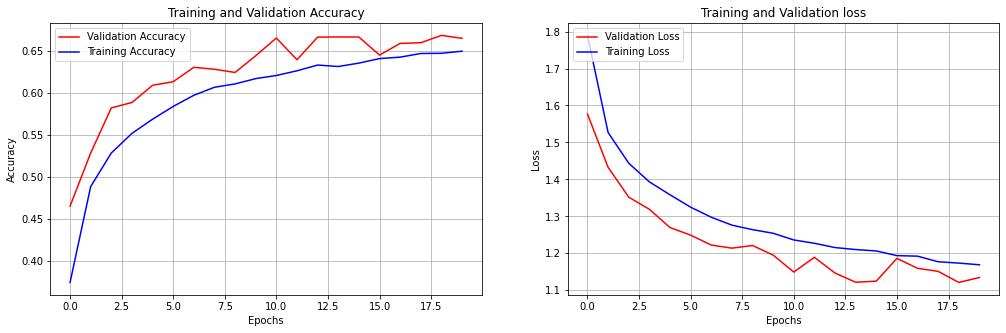

time: 599 ms (started: 2022-07-24 20:13:33 +00:00)


In [87]:
plot_history(model)

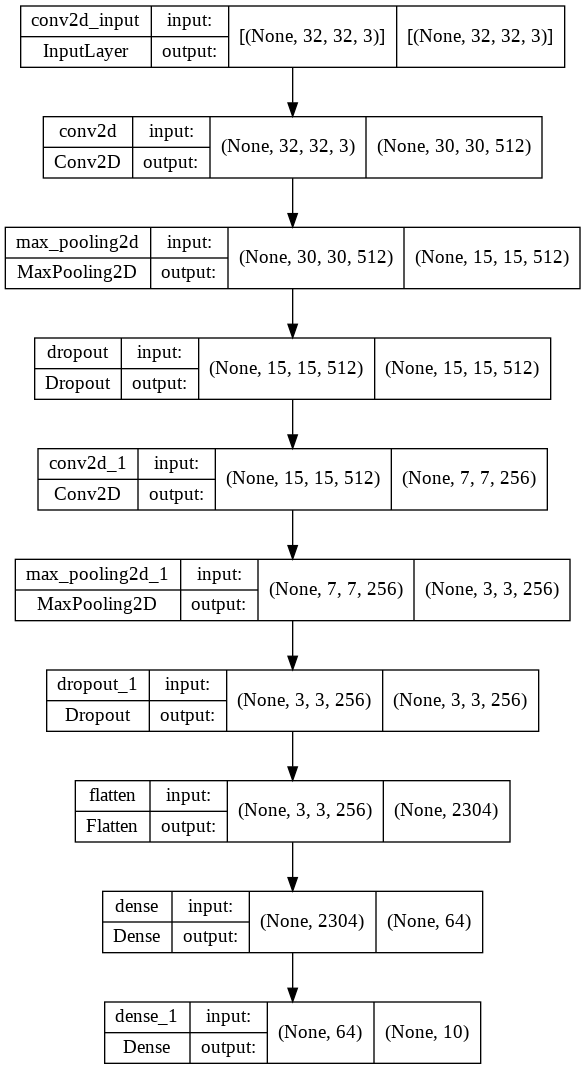

time: 374 ms (started: 2022-07-24 20:13:34 +00:00)


In [88]:
keras.utils.plot_model(model, "Exp6_CIFAR10.png", show_shapes=True)

In [89]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 256)         0

In [90]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 4ms/step - loss: 1.1411 - accuracy: 0.6548
test set accuracy:  65.47999978065491
time: 2.73 s (started: 2022-07-24 20:13:34 +00:00)


In [91]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.55      0.65      1000
           1       0.86      0.71      0.78      1000
           2       0.61      0.43      0.50      1000
           3       0.50      0.41      0.45      1000
           4       0.57      0.63      0.60      1000
           5       0.53      0.65      0.58      1000
           6       0.63      0.86      0.73      1000
           7       0.74      0.68      0.70      1000
           8       0.64      0.88      0.74      1000
           9       0.76      0.75      0.76      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.65     10000
weighted avg       0.67      0.65      0.65     10000

Accuracy Score: 0.6548
Root Mean Square Error: 2.4747323087558377
time: 1.13 s (started: 2022-07-24 20:13:37 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


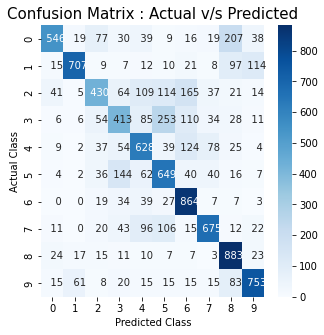

time: 1.52 s (started: 2022-07-24 20:13:38 +00:00)


In [92]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [93]:
# # Extracts the outputs of all layers:
# layer_outputs = [layer.output for layer in model.layers]

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# # Get activation values for the last dense layer
# activations = activation_model.predict(X_valid[:2000])
# dense_layer_activations = activations[-3]
# output_layer_activations = activations[-1]

time: 1.59 ms (started: 2022-07-24 20:13:40 +00:00)


In [94]:
# # Reduce the dimension using T-SNE to visualize i n a scatterplot
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
# tsne_results = tsne.fit_transform(dense_layer_activations)

# # Scaling
# tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

time: 1.33 ms (started: 2022-07-24 20:13:40 +00:00)


In [95]:
# cmap = plt.cm.tab10
# plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:2000], s=10, cmap=cmap)
# plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(tsne_results):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#             position, bboxprops={"lw": 1})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

time: 1.64 ms (started: 2022-07-24 20:13:40 +00:00)


## E7: CNN with 3 convolution/max pooling layers with drop out and  regularization

In [ ]:
%load_ext autotime
time_callback_7 = TimeHistory()
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=64, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train,Y_train, validation_data = (X_valid,Y_valid), epochs=20, batch_size=512 , verbose = 1, callbacks = [time_callback_7])
results['exp7'] = history.history

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Epoch 1/20
79/79 [==============================] - 9s 100ms/step - loss: 2.1747 - accuracy: 0.2963 - val_loss: 2.2602 - val_accuracy: 0.3597
Epoch 2/20
48/79 [=================>............] - ETA: 2s - loss: 1.6998 - accuracy: 0.4519

In [ ]:
plot_history(model)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "Exp7_CIFAR10.png", show_shapes=True)

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

In [ ]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [ ]:
# # Extracts the outputs of all layers:
# layer_outputs = [layer.output for layer in model.layers]

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# # Get activation values for the last dense layer
# activations = activation_model.predict(X_valid[:2000])
# dense_layer_activations = activations[-3]
# output_layer_activations = activations[-1]

In [ ]:
# # Reduce the dimension using T-SNE to visualize i n a scatterplot
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
# tsne_results = tsne.fit_transform(dense_layer_activations)

# # Scaling
# tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:
# cmap = plt.cm.tab10
# plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:2000], s=10, cmap=cmap)
# plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(tsne_results):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#             position, bboxprops={"lw": 1})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

## E8 : CNN with 5 convolution/max pooling layers with drop out and regularization

In [ ]:
%reload_ext autotime
time_callback_8 = TimeHistory()
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=128, kernel_size=(2, 2), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(layers.BatchNormalization())

model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), activation=tf.nn.relu, padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D((1, 1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=64, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

#model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(X_train,Y_train, validation_data = 
                    (X_valid,Y_valid), 
                    epochs=20, batch_size=512 , 
                    verbose = 1, callbacks = [time_callback_8])


results['exp8'] = history.history

In [ ]:
keras.utils.plot_model(model, "Exp18_CIFAR10.png", show_shapes=True)

In [ ]:
model.summary()

In [ ]:
plot_history(model)

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

In [ ]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [ ]:
X_valid.shape

In [ ]:
# # Extracts the outputs of all layers:
# layer_outputs = [layer.output for layer in model.layers]

# # Creates a model that will return these outputs, given the model input:
# activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# # Get activation values for the last dense layer
# activations = activation_model.predict(X_valid[:5000])
# dense_layer_activations = activations[-3]
# output_layer_activations = activations[-1]

In [ ]:
# # Reduce the dimension using T-SNE to visualize i n a scatterplot
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
# tsne_results = tsne.fit_transform(dense_layer_activations)

# # Scaling
# tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [ ]:
# cmap = plt.cm.tab10
# plt.figure(figsize=(16,10))
# scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=Y_valid[:2000], s=10, cmap=cmap)
# plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

# image_positions = np.array([[1., 1.]])
# for index, position in enumerate(tsne_results):
#     dist = np.sum((position - image_positions) ** 2, axis=1)
#     if np.min(dist) > 0.02: # if far enough from other images
#         image_positions = np.r_[image_positions, [position]]
#         imagebox = mpl.offsetbox.AnnotationBbox(
#             mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#             position, bboxprops={"lw": 1})
#         plt.gca().add_artist(imagebox)
# plt.axis("off")
# plt.show()

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

## E9 : CNN with 3 convolution/max pooling, regularization and dropout layer + Hyper parameter tuning

In [ ]:
my_dir = '/content/gdrive/MyDrive'

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model = models.Sequential()
  model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
  model.add(layers.MaxPool2D((2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
  model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
  model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
  model.add(layers.Dense(units=10, activation=tf.nn.softmax))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory= my_dir,
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train_norm, y_train, epochs=50, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
%load_ext autotime
time_callback_9 = TimeHistory()
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
 
model.add(layers.Dense(units=352, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax)) 

# For use with non-categorical labels
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model.fit(X_train,Y_train, validation_data = (X_valid,Y_valid), epochs=20, verbose = 1, 
                    callbacks = [time_callback_9])
results['exp9'] = history.history

In [ ]:
keras.utils.plot_model(model, "Exp9_CIFAR10.png", show_shapes=True)

In [ ]:
model.summary()

In [ ]:
plot_history(model)

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

In [ ]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

plt.show();

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(exp_test_preds[0:20], 
                  columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap='YlOrRd')

## E10 : CNN with 3 convolution/max pooling, regularization and dropout layer + Hyper parameter tuning

In [ ]:
def model_builder1(hp):
  model = keras.Sequential()
  model = models.Sequential()
  model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
  model.add(layers.MaxPool2D((2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
  model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
  model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
  model.add(layers.Dense(units=10, activation=tf.nn.softmax))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
my_dir = '/content/gdrive/MyDrive'

In [ ]:
tuner = kt.Hyperband(model_builder1,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory= my_dir,
                     project_name='intro_to_kt1')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train_norm, y_train, epochs=50, validation_split=0.1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
%load_ext autotime
time_callback_10 = TimeHistory()
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
 
model.add(layers.Dense(units=480, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=10, activation=tf.nn.softmax)) 

# For use with non-categorical labels
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),           
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

#FITTING, and storing for plotting and call backs
history = model.fit(X_train,Y_train, validation_data =
                    (X_valid,Y_valid), epochs=20, verbose = 1, batch_size=512 , callbacks = [time_callback_10])
results['exp10'] = history.history

In [ ]:
keras.utils.plot_model(model, "Exp10_CIFAR10.png", show_shapes=True)

In [ ]:
model.summary()

In [ ]:
plot_history(model)

In [ ]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

In [ ]:
exp_test_preds = model.predict(x_test_norm)
from sklearn.preprocessing import normalize
plot_confusion_matrix(y_test, exp_test_preds.argmax(axis = 1));

KeyError: ignored

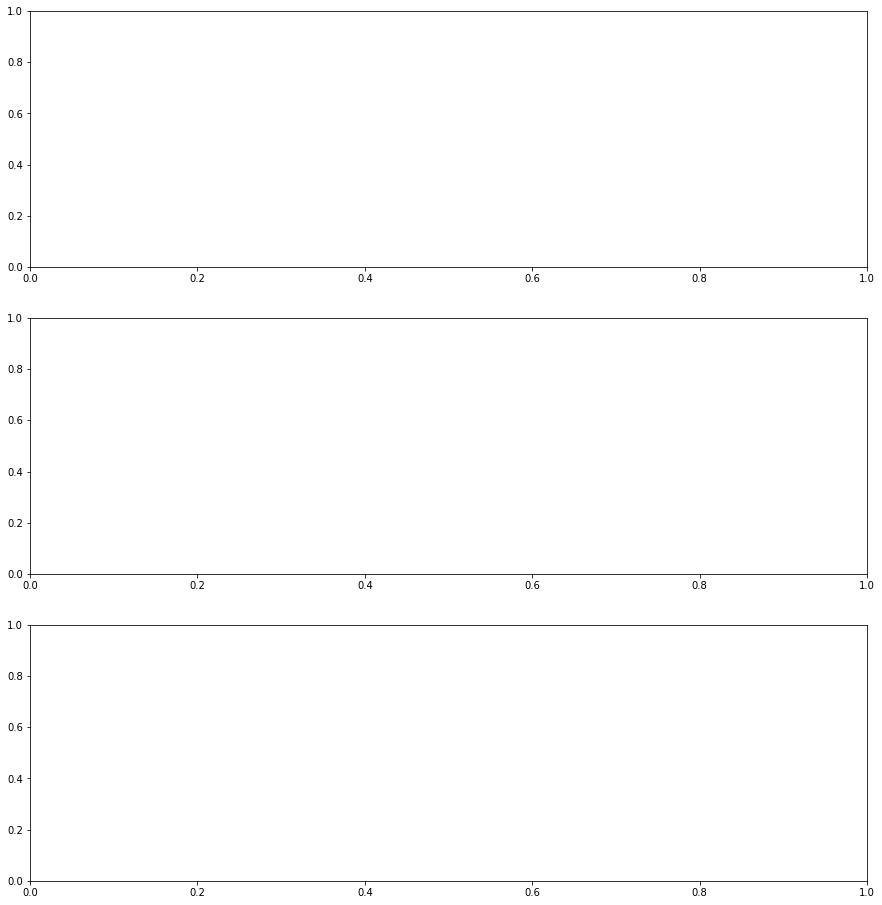

time: 463 ms (started: 2022-07-24 19:58:35 +00:00)


In [114]:
def plot_accuracies(ax):
  ax.plot(results['exp1']['val_accuracy'], label = "Exp1")
  ax.plot(results['exp2']['val_accuracy'], label = "Exp2")
  ax.plot(results['exp3']['val_accuracy'], label = "Exp3")
  ax.plot(results['exp4']['val_accuracy'], label = "Exp4")
  ax.plot(results['exp5']['val_accuracy'], label = "Exp5")
  ax.plot(results['exp6']['val_accuracy'], label = "Exp6")
  ax.plot(results['exp7']['val_accuracy'], label = "Exp7")
  ax.plot(results['exp8']['val_accuracy'], label = "Exp8")
  ax.plot(results['exp9']['val_accuracy'], label = "Exp9")
  ax.plot(results['exp10']['val_accuracy'], label = "Exp10")

  ax.grid();
  ax.legend();



def plot_losses(ax):
  ax.plot(results['exp1']['val_loss'], label = "Exp1")
  ax.plot(results['exp2']['val_loss'], label = "Exp2")
  ax.plot(results['exp3']['val_loss'], label = "Exp3")
  ax.plot(results['exp4']['val_loss'], label = "Exp4")
  ax.plot(results['exp5']['val_loss'], label = "Exp5")
  ax.plot(results['exp6']['val_loss'], label = "Exp6")
  ax.plot(results['exp7']['val_loss'], label = "Exp7")
  ax.plot(results['exp8']['val_loss'], label = "Exp8")
  ax.plot(results['exp9']['val_loss'], label = "Exp9")
  ax.plot(results['exp10']['val_loss'], label = "Exp10")

  ax.grid();
  ax.legend();


def plot_times(ax):
  ax.plot(time_callback_1.times, label = "Exp1")
  ax.plot(time_callback_2.times, label = "Exp2")
  ax.plot(time_callback_3.times, label = "Exp3")
  ax.plot(time_callback_4.times, label = "Exp4")
  ax.plot(time_callback_5.times, label = "Exp5")
  ax.plot(time_callback_6.times, label = "Exp6")
  ax.plot(time_callback_7.times, label = "Exp7")
  ax.plot(time_callback_8.times, label = "Exp8")
  ax.plot(time_callback_9.times, label = "Exp9")
  ax.plot(time_callback_10.times, label = "Exp10")

  ax.grid();
  ax.legend();


fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize = (15,16))
plot_accuracies(ax1)
plot_losses(ax2)
plot_times(ax3)

In [ ]:
df = pd.concat([
           pd.DataFrame(results['exp1']),
           pd.DataFrame(results['exp2']),
           pd.DataFrame(results['exp3']),
           pd.DataFrame(results['exp4']),
           pd.DataFrame(results['exp5']),
           pd.DataFrame(results['exp6']),
           pd.DataFrame(results['exp7']),
           pd.DataFrame(results['exp8']),
           pd.DataFrame(results['exp9']),
           pd.DataFrame(results['exp10']),

]) 

In [ ]:
df['epochs'] = [*range(1,21)]*12

In [ ]:
df['time'] =  pd.concat(map(pd.DataFrame,[time_callback_1.times,
  time_callback_2.times,
  time_callback_3.times,
  time_callback_4.times,
  time_callback_5.times,
  time_callback_6.times,
  time_callback_7.times,
  time_callback_8.times,
  time_callback_9.times,
  time_callback_10.times,
]), axis = 1).melt()['value'].values


e = 20
l = ['Exp1', 'Exp2', 'Exp3', 'Exp4','Exp5', 'Exp6', 'Exp7', 'Exp8','Exp9', 'Exp10']
df['model'] = [ele for ele in l for i in range(e)]

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,5))
sns.barplot('epochs', 'time', hue = 'model', data = df, palette = 'Paired', ax = ax);
plt.grid();

In [ ]:
df.to_csv('time.csv')